# Mammogram Analysis Challenge

A mammogram is an X-ray of the breast used primarily by radiologists to detect signs of breast cancer like abnormal masses and calcifications (signs of a possible tumor). Sometimes these abnormalities are obvious, sometimes they are not. In younger women especially, masses and calcifications can be difficult for radiologists to detect in a mammogram due to dense surrounding tissue. This makes mammograms a great candidate for machine learning analysis. A program that can detect abnormalities with high accuracy could be used to catch radiologists' mistakes and potentially save lives (https://giving.massgeneral.org/machine-learning-breast-cancer-screening)


  <h3><center>Mammogram Image</center></h3>

<center><img src="https://github.com/BeaverWorksMedlytics2020/Data_Public/raw/master/Images/Week3/mammogram_image.png" width=400></center>


In this code, we have classified mammogram segments into two classes (positive for an abnormality and negative). 



## Imports

In [ ]:
# File manipulation and IO (input/output)
import os
import pickle
import zipfile

# Import numerical and dataframe handling
import numpy as np
import scipy
import pandas as pd

# Data preprocessing
from PIL import Image
from sklearn.utils import shuffle

# Model scoring
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# Import standard machine learning machinery
import tensorflow as tf

# Garbage collection (for saving RAM during training)
import gc

# Import plotting functionality
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import MultipleLocator
import matplotlib



2023-09-26 20:27:27.898012: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 20:27:28.122787: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-26 20:27:28.122820: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-09-26 20:27:28.142069: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-26 20:27:29.262622: W tensorflow/stream_executor/platform/de

In [ ]:
# Set plotting preferences
%matplotlib inline
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

## Download the images and labels from our GitHub data repository

This dataset is from the publicly available Digital Database for Screening Mammography (DDSM) and the Curated Breast Imaging Subset of DDSM (CBIS-DDSM).

The binary labels are 0 (negative for an abnormality) and 1 (positive for an abnormality). 
In the following cell, we download the images and labels from our GitHub data repository.

In [ ]:
# Set the path to the files on GitHub
github_data_path = 'https://raw.githubusercontent.com/Medlytics2022/Week3/master/Datasets/ChallengeProject/'

# Downloads 3 zip files from github containing training, validation, and test images
os.system('wget '+ os.path.join(github_data_path, 'Mamm_Images_Test.zip'))
os.system('wget '+ os.path.join(github_data_path, 'Mamm_Images_Train.zip'))
os.system('wget '+ os.path.join(github_data_path, 'Mamm_Images_Val.zip'))

# Downloads the binary labels for the dataset
os.system('wget ' + os.path.join(github_data_path,'train_binary_labels.csv'))
os.system('wget ' + os.path.join(github_data_path,'val_binary_labels.csv'))


--2023-09-26 20:27:31--  https://raw.githubusercontent.com/Medlytics2022/Week3/master/Datasets/ChallengeProject/Mamm_Images_Test.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7907370 (7.5M) [application/zip]
Saving to: ‘Mamm_Images_Test.zip.17’

     0K .......... .......... .......... .......... ..........  0% 45.7M 0s
    50K .......... .......... .......... .......... ..........  1% 43.0M 0s
   100K .......... .......... .......... .......... ..........  1% 45.6M 0s
   150K .......... .......... .......... .......... ..........  2% 60.0M 0s
   200K .......... .......... .......... .......... ..........  3%  191M 0s
   250K .......... .......... .......... .......... ..........  3% 87.1M 0s
   300K .......... .......... .......... .......... ........

0

### Unzip the Image Files

The following cell unzips the image files and prepares them to be loaded into memory.

In [ ]:
### Unzip the image data and populate dataframe objects ###
# Unzip all files to respective folders in current directory
zip_ref = zipfile.ZipFile('Mamm_Images_Train.zip', 'r')
zip_ref.extractall()
zip_ref.close()

zip_ref = zipfile.ZipFile('Mamm_Images_Val.zip', 'r')
zip_ref.extractall()
zip_ref.close()

zip_ref = zipfile.ZipFile('Mamm_Images_Test.zip', 'r')
zip_ref.extractall()
zip_ref.close()

## Loading the Data into Memory

The following data will be loaded into the following variables:

* **train_binary_labels_df**: 2 column pandas df where each row contains a label (0 or 1) and the unique ID of the image the label corresponds to. 5500 samples/rows.
* **train_images_df**: 2 column pandas df where the rows contain a 299x299 numpy array of the (greyscale) pixel values in the image and the unique ID of the image. 5500 samples/rows. 
* **train_images**: A np array (5500, 299, 299) containing all training images (may be easier to deal with than the df)
* **test_images_df**: 2 column pandas df where the rows contain a 299x299 numpy array of the (greyscale) pixel values in the image and the unique ID of the image. 1500 samples/rows.
* **test_images**: A np array (1500, 299, 299) containing all training images (may be easier to deal with than the df)



### Store Images and Labels in Numpy Arrays and Dataframes

The following cell will load the images and labels into a pair of numpy ndarray and pandas dataframe objects.

In [ ]:
# Use pd.read_csv to open csv file contents to pandas dataframes
train_binary_labels_df = pd.read_csv('train_binary_labels.csv', header=None)
val_binary_labels_df = pd.read_csv('val_binary_labels.csv', header=None)


# Concatenate train/validation labels into one set
#We will separate it later for our own train/val/mocktest split
train_binary_labels_df = pd.concat([train_binary_labels_df, val_binary_labels_df], axis=0, ignore_index = True)


# Add columns to train_binary_labels_df dataframe that contains unique
# (original) indices of train data
unique_indices_df = pd.DataFrame(list(range(5500)))
train_binary_labels_df = pd.concat([train_binary_labels_df, unique_indices_df], axis=1)
train_binary_labels_df.columns = ['Label', 'Unique_Index']


train_binary_labels_df.head(10)
# Load images from file and save to both
# 1) dataframe objects
# 2) numpy arrays of shape (num_examples, num_pixels_wide, num_pixels_high)

# Read in train images (from both train and val directories) to ndarray
train_images = np.zeros((5500,299,299), dtype=np.uint8)
for ind in range(5000):
  im = plt.imread('Mamm_Images_Train/image' + str(ind) + '.jpg')
  train_images[ind, :, :] = im
  
for ind in range(500):
  im = plt.imread('Mamm_Images_Val/image' + str(ind) + '.jpg')
  train_images[ind + 5000, :, :] = im

# Read in test images to ndarray
test_images = np.zeros((1500,299,299), dtype=np.uint8)
for ind in range(1500):
  im = plt.imread('Mamm_Images_Test/image' + str(ind) + '.jpg')
  test_images[ind, :, :] = im

#dataframes that contain the same information as the ndarrays
# The N-th row contains a 299x299 ndarray, and a unique index for that image
train_images_df = pd.DataFrame([[train_images[i,:,:] for i in range(train_images.shape[0])]])
train_images_df = train_images_df.transpose() #changes the rows to columns and the columns to rows.
unique_indices_df = pd.DataFrame(list(range(5500)), dtype = np.int)
train_images_df = pd.concat([train_images_df, unique_indices_df], axis = 1)
train_images_df.columns = ['Images', 'Unique_Index']

test_images_df = pd.DataFrame([[test_images[i,:,:] for i in range(test_images.shape[0])]])
test_images_df = test_images_df.transpose()
unique_indices_df = pd.DataFrame(list(range(5500, 7000)), dtype = np.int)
test_images_df = pd.concat([test_images_df, unique_indices_df], axis = 1)
test_images_df.columns = ['Images', 'Unique_Index']



/tmp/ipykernel_96/3933248169.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  unique_indices_df = pd.DataFrame(list(range(5500)), dtype = np.int)
/tmp/ipykernel_96/3933248169.py:49: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

## Data Visualization

The cell below shows how the mammogram images look like. They are 299x299 pixel greyscale images of sections of mammograms. Generally, masses and calcifications show up as blobs of various size, shape, and brightness. As mentioned already, dense tissue shows up brighter on mammograms and it can be dificult to spot an abnormality in mammograms with denser tissue. Each image is labeled with its binary labels.


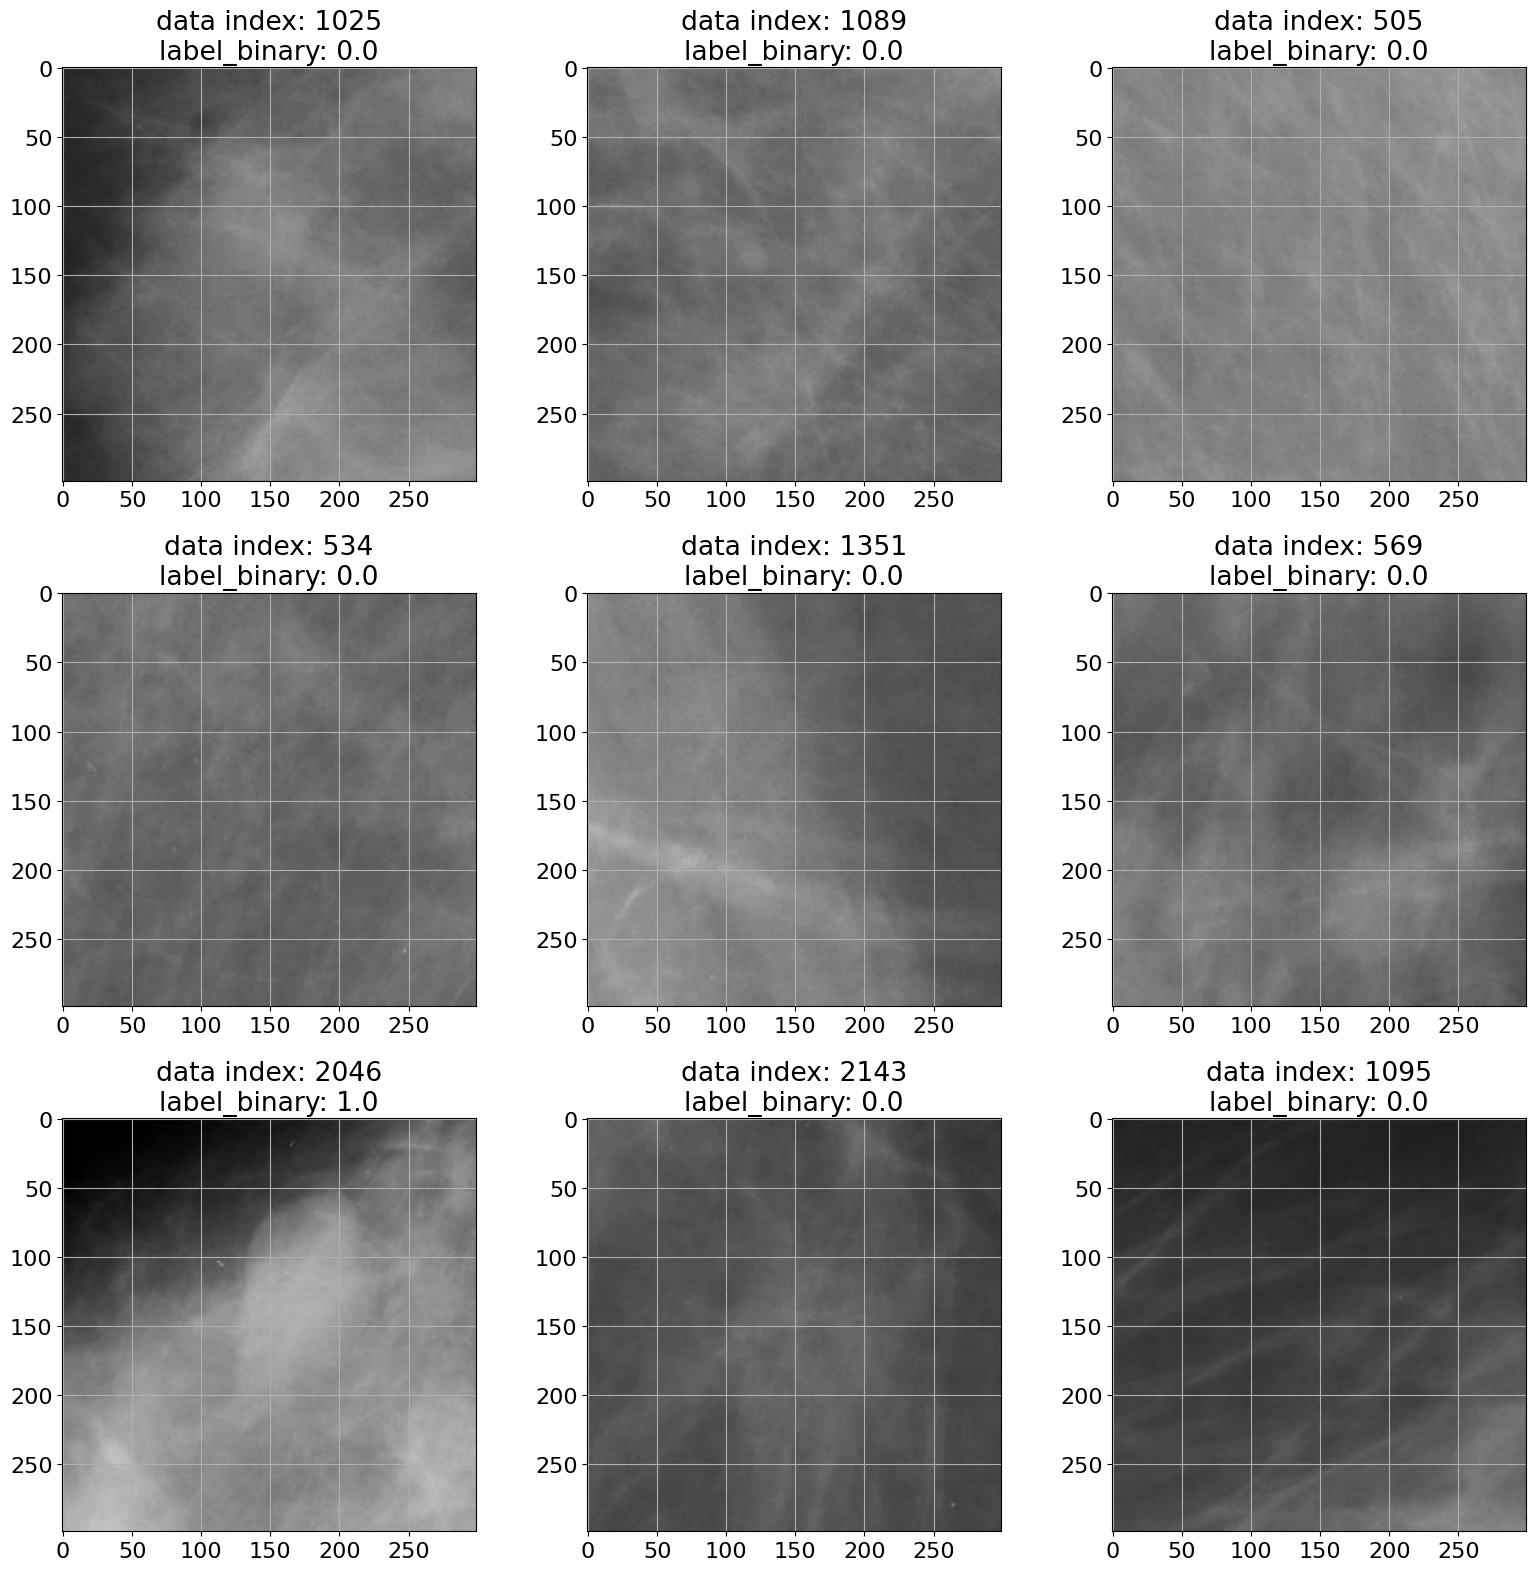

In [ ]:
### Visualize Images in Training Set

fig = plt.figure(figsize = (16,16))

for i in range(9): # change these numbers to explore the training dataset further
  imgInd = np.random.randint(0, len(train_images_df))
  ax = plt.gcf().add_subplot(3, 3, i+1)
  ax.imshow(train_images[imgInd], cmap='gray', vmin=0, vmax=255)
  ax.set_title("data index: " + str(imgInd) + "\nlabel_binary: " +
            str(train_binary_labels_df.iloc[imgInd,0]))
  
  #set major tick marks every 50 pixels
  ax.xaxis.set_major_locator(MultipleLocator(50))
  ax.yaxis.set_major_locator(MultipleLocator(50))

  #turn on grid lines
  ax.grid(True)

fig.tight_layout()

# Binary CNN Classifier

In [ ]:
### Create one-hot labels
train_binary_labels = train_binary_labels_df["Label"]
#convert labels to onehot, ensure type is float32
train_binary_labels = tf.keras.utils.to_categorical(train_binary_labels, 2).astype(np.float32)

In [ ]:
### Shuffle and partition labeled data

train_images_shuffled, train_binary_labels_shuffled = shuffle(train_images, train_binary_labels, random_state = 25)

#--Partition into train/val/mock_test--

#In a 2D convolution, we need another dimension on all 
#train/val/mocktest data. This dimension corresponds to "number of channels"
#(an RGB image would have 3 channels, for example). Our images only have one 
#channel, but the 2D convolution layers still expect the last data dimension to 
#correspond to channel. 


val_size = 1000
mocktest_size = 500

mocktest_data = train_images_shuffled[0:mocktest_size, :, :, np.newaxis]
mocktest_binary_labels = train_binary_labels_shuffled[0:mocktest_size, :]

val_data = train_images_shuffled[mocktest_size:mocktest_size+val_size, :, :, np.newaxis]
val_binary_labels = train_binary_labels_shuffled[mocktest_size:mocktest_size+val_size, :]

partial_train_data = train_images_shuffled[mocktest_size+val_size:,:,:, np.newaxis]
tr_binary_labels = train_binary_labels_shuffled[mocktest_size+val_size:,:]

print(mocktest_data.shape)
print(mocktest_binary_labels.shape)

print(val_data.shape)
print(val_binary_labels.shape)

print(partial_train_data.shape)
print(tr_binary_labels.shape)

(500, 299, 299, 1)
(500, 2)
(1000, 299, 299, 1)
(1000, 2)
(4000, 299, 299, 1)
(4000, 2)


In [ ]:
### Define a convolutional neural network structure and compile model

model = tf.keras.Sequential()


model.add(tf.keras.layers.Conv2D(filters = 16, kernel_size = 8, padding = 'valid',
                                 activation=tf.nn.relu, 
                                 input_shape=(partial_train_data.shape[1],
                                              partial_train_data.shape[2], 1)))


#use 2D max pooling to reduce size of convolution output before flattening
model.add(tf.keras.layers.MaxPooling2D(pool_size = (10,10),
                                       strides=3, 
                                       padding = 'valid',
                                       data_format = 'channels_last'))


#Take all activations from previous layer and flatten them 
#(often done before a fully connected layer)
model.add(tf.keras.layers.Flatten())

#insert a dense layer with 64 units
model.add(tf.keras.layers.Dense(64, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(32, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(32, activation=tf.nn.relu))
#we end with a softmax to ensure outputs of neural network are in range of 0 to 1
#(sortof like probabilities would)
model.add(tf.keras.layers.Dense(2, activation=tf.nn.softmax)) 

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 292, 292, 16)      1040      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 95, 95, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 144400)            0         
                                                                 
2023-09-26 20:27:45.032339: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-09-26 20:27:45.032389: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-26 20:27:45.032413: I tensorflow/

In [ ]:
### Train Model

#This function is called after each epoch
#(It will ensure that your training process does not consume all available RAM)
class garbage_collect_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    gc.collect()

history = model.fit(partial_train_data, # Train examples
          tr_binary_labels, # Train labels
          epochs=10, # number of epochs (passes through data during training)
          batch_size= 100, # number of points to consider in each optimizer iteration
          callbacks = [garbage_collect_callback()],
          validation_data=(val_data, val_binary_labels), #data to use for validation
          verbose=1) #will print information about optimization process



test_binary_pred = model.predict(mocktest_data)
scores = model.evaluate(mocktest_data, mocktest_binary_labels, verbose = 0)
print('\nTesting model on mock_test set:')
print(f'Model Loss: {scores[0]:.3f}, Model Accuracy: {scores[1]:.3f}')

Epoch 1/10
40/40 [==============================] - 463s 12s/step - loss: 1.9878 - accuracy: 0.6155 - val_loss: 0.6497 - val_accuracy: 0.6770
Epoch 2/10
 9/40 [=====>........................] - ETA: 5:36 - loss: 0.6619 - accuracy: 0.6733

KernelInterrupted: Execution interrupted by the Jupyter kernel.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=941a78b9-6400-4aee-91e0-2651ceaf49dd' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>